In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import time
import jax
import jax.numpy as jnp
import jax.scipy.linalg as jsp_linalg
import matplotlib.pyplot as plt

In [2]:
'''
def make_markov_Q(key, batch, n, n_cycles=1):
    keys = jax.random.split(key, batch)

    # 所有可能边 (上三角, i<j)
    ii, jj = jnp.triu_indices(n, k=1)
    all_edges = jnp.stack([ii, jj], axis=-1)  # (E, 2)
    E = all_edges.shape[0]

    def build_one(k):
        k1, k2, k3 = jax.random.split(k, 3)

        # step1: 随机生成树
        parents = jax.random.randint(k1, (n-1,), 0, jnp.arange(1, n))
        tree_edges = jnp.stack([jnp.arange(1, n), parents], axis=-1)

        # step2: 随机采样额外边（从全集里直接采样）
        extra_idx = jax.random.choice(k2, E, (n_cycles,), replace=False)
        extra_edges = all_edges[extra_idx]

        # 合并
        all_edges_final = jnp.concatenate([tree_edges, extra_edges], axis=0)

        # step3: 构建邻接矩阵
        M = jnp.zeros((n, n))
        rates = jax.random.uniform(k3, (all_edges_final.shape[0],))
        def add_edge(i, M):
            u, v = all_edges_final[i]
            r = rates[i]
            M = M.at[u, v].set(r)
            M = M.at[v, u].set(r)
            return M
        M = jax.lax.fori_loop(0, all_edges_final.shape[0], add_edge, M)
        return M

    adj = jax.vmap(build_one)(keys)

    # step4: Q 矩阵
    row_sum = jnp.sum(adj, axis=-1)
    Q = adj.at[..., jnp.arange(n), jnp.arange(n)].add(-row_sum)
    return Q
'''

def make_markov_Q(key, batch, n):
    """
    densely connected Markov Q-matrix
    """
    Q = jax.random.uniform(key, (batch, n, n))  
    Q = Q.at[..., jnp.arange(n), jnp.arange(n)].set(0.0)
    rowsum = jnp.sum(Q, axis=-1)
    Q = Q.at[..., jnp.arange(n), jnp.arange(n)].set(-rowsum)
    return Q


def solver_numpy(A, b):
    return jnp.linalg.solve(A, b)

def solver_scipy(A, b):
    return jsp_linalg.solve(A, b, assume_a="gen")

def solver_lu(A, b):
    lu, piv = jsp_linalg.lu_factor(A)
    return jsp_linalg.lu_solve((lu, piv), b)

def solver_numpy_vmap(A, b):
    return jax.vmap(lambda a, bb: jnp.linalg.solve(a, bb))(A, b)

# --------- JIT  ---------
solver_numpy_jit = jax.jit(solver_numpy)
solver_scipy_jit = jax.jit(solver_scipy)
solver_lu_jit = jax.jit(solver_lu)
solver_numpy_vmap_jit = jax.jit(solver_numpy_vmap)

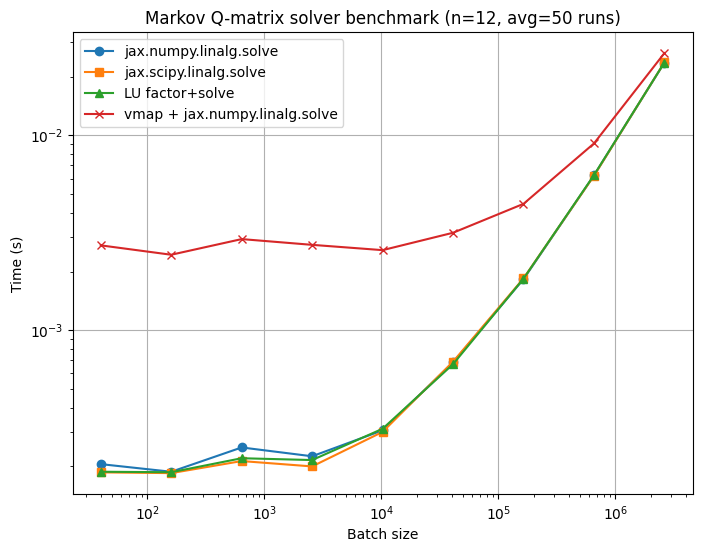

In [ ]:
factor = 1
matrix_size = 12 * factor 
batch_sizes = [10*4**i for i in range(1,10)]  
num_repeats = 50
dt = 0.01  

# --------- Benchmark ---------
times_numpy, times_scipy, times_lu, times_numpy_vmap = [], [], [], []

for batch in batch_sizes:
    key = jax.random.key(int(batch))
    Q = make_markov_Q(key, batch, matrix_size)
    A = jnp.eye(matrix_size) - dt * Q
    b = jax.random.normal(key, (batch, matrix_size, 1))

    # warm-up
    for solver in [solver_numpy_jit, solver_scipy_jit, solver_lu_jit]:
        solver(A, b).block_until_ready()

    t_numpy, t_scipy, t_lu, t_numpy_vmap = [], [], [], []
    for _ in range(num_repeats):
        t0 = time.time()
        solver_numpy_jit(A, b).block_until_ready()
        t_numpy.append(time.time() - t0)

        t0 = time.time()
        solver_scipy_jit(A, b).block_until_ready()
        t_scipy.append(time.time() - t0)

        t0 = time.time()
        solver_lu_jit(A, b).block_until_ready()
        t_lu.append(time.time() - t0)

        t0 = time.time()
        solver_numpy_vmap_jit(A, b).block_until_ready()
        t_numpy_vmap.append(time.time() - t0)

    times_numpy.append(sum(t_numpy) / num_repeats)
    times_scipy.append(sum(t_scipy) / num_repeats)
    times_lu.append(sum(t_lu) / num_repeats)
    times_numpy_vmap.append(sum(t_numpy_vmap) / num_repeats)


# --------- plot ---------
plt.figure(figsize=(8,6))
plt.plot(batch_sizes, times_numpy, marker="o", label="jax.numpy.linalg.solve")
plt.plot(batch_sizes, times_scipy, marker="s", label="jax.scipy.linalg.solve")
plt.plot(batch_sizes, times_lu, marker="^", label="LU factor+solve")
plt.plot(batch_sizes, times_numpy_vmap, marker="x", label="vmap + jax.numpy.linalg.solve")
plt.xlabel("Batch size")
plt.ylabel("Time (s)")
plt.title(f"Markov Q-matrix solver benchmark (n={matrix_size}, avg={num_repeats} runs)")
plt.legend()
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.show()


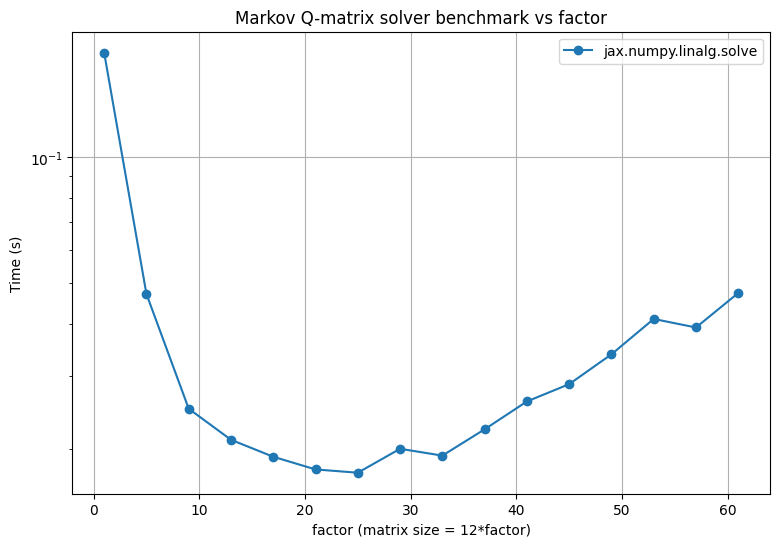

In [ ]:
# --------- Benchmark vs factor ---------
num_repeats = 10
dt = 0.01
factors = range(1, 64, 4)   
times_numpy = []
for factor in factors:
    n = 12 * factor
    batch = max(1, int(20000000 / factor**3))  
    key = jax.random.key(factor)

    Q = make_markov_Q(key, batch, n)
    A = jnp.eye(n) - dt * Q
    b = jax.random.normal(key, (batch, n, 1))

    # warm-up
    for solver in [solver_numpy_jit,]:
        solver(A, b).block_until_ready()

    t_numpy  = 0.0
    for _ in range(num_repeats):
        t0 = time.time(); solver_numpy_jit(A, b).block_until_ready(); t_numpy += time.time() - t0

    times_numpy.append(t_numpy / num_repeats)

# --------- plot ---------
plt.figure(figsize=(9,6))
plt.plot(factors, times_numpy, marker="o", label="jax.numpy.linalg.solve")
for i, f in enumerate(factors):
    batch = max(1, int(100_000_000 / f**3))
    plt.annotate(str(batch),
                 (f, times_numpy[i]),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha="center",
                 fontsize=8,
                 color="black")
plt.xlabel("factor (matrix size = 12*factor)")
plt.ylabel("Time (s)")
plt.title("Markov Q-matrix solver benchmark vs factor")
plt.legend()
plt.grid(True)
plt.yscale("log")
plt.show()
